In [31]:
install.packages("janitor")

library(repr)
library(tidyverse)
library(tidymodels)
library(readr)
library(janitor)
library(dplyr)
library(cowplot)

options(digits = 4)
set.seed(2)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### Group project proposal

# Data Analysis on Air Quality Index of Counties in the US

DSCI100 group project-006-14  
Group member:  
`Dorothy GER`  
`Charlie Hua`  
`Callie Phelps`  
`Hancheng Zhang 29643160`


## Introduction

For this project we will be using the programming language R as it is useful for plotting statistical graphics. Our data set that we have chosen to work with is Annual AQI (Air quality index) by country for the year 2021. A higher AQI indicates more pollutents in the air and worse quality of air. Using this data set we want answer the question that does a county have satisfying or not satisfying air quality based on 90th percentile AQI, where higher or equal to 60 is described as "not satisfying" and lower than 60 "satisfying", in order to determine if a county has existing or potential air quality issues. A higher 90th percentile AQI indicates that a county has overall higher AQI (worse air quality). 

This dataset covers the annual summary data of AQI by county like 90th percentile AQI which indicates the range of a county's AQI fall into. There are columns in the dataset that have different types of pollutants(CO, NO2, ozone, SO2, PM2.5, PM10) that represent the numbers of days when they exceeded the primary/secondary air quality standard, as well the columns that range from good days to hazardous days are determined by the daily monitoring criteria.

## Preliminary exploratory data analysis

This data analysis project is based on the "annual_aqi_by_county_2021.csv" dataset. It can be directly read from the web as follow.

In [32]:
url <- "https://raw.githubusercontent.com/Hansen0014/Air-quality-data/main/annual_aqi_by_county_2021.csv"
Air_quality <- read.csv(url)
head(Air_quality)

,State,County,Year,Days.with.AQI,Good.Days,Moderate.Days,Unhealthy.for.Sensitive.Groups.Days,Unhealthy.Days,Very.Unhealthy.Days,Hazardous.Days,Max.AQI,X90th.Percentile.AQI,Median.AQI,Days.CO,Days.NO2,Days.Ozone,Days.SO2,Days.PM2.5,Days.PM10
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alabama,Baldwin,2021,203,190,13,0,0,0,0,61,49,37,0,0,166,0,37,0
2,Alabama,Clay,2021,73,66,7,0,0,0,0,67,50,28,0,0,0,0,73,0
3,Alabama,DeKalb,2021,239,211,28,0,0,0,0,84,51,38,0,0,213,0,26,0
4,Alabama,Elmore,2021,180,177,3,0,0,0,0,87,45,34,0,0,180,0,0,0
5,Alabama,Etowah,2021,204,178,26,0,0,0,0,77,54,38,0,0,158,0,46,0
6,Alabama,Jefferson,2021,182,90,90,1,0,1,0,213,74,51,2,1,65,0,113,1


Since we want to predict does a county face existing/potential air quality issues. We decide to set a bar towards `90th_Percentile_AQI`. Countries with 90th percentile AQI **higher than or equal to 60** would be defined as "`not satisfying`" type(having existing/potential air quality), and counties with 90th percentile AQI **lower than 60** would be defined as `satisfying` type(having no air quality issue).

In order to achieve this goal, we need to wangle this data to a clean and tidy form without other unnecessary columns.  
Firstly, we chosed "`days_Ozone`","`good_days`","`days_pm2.5`" as our **predictor variable**.  
Due to these three variable are based on "`Days_with_AQI`", we can not directly use them as comparison variable since every county has different `Days_with_AQI`. So we mutated them to the percentage form.  
Then we divided the observations to two groups---"`not satisfying`" and "`satisifying`" based on their "`90th_Percentile_AQI`".

In [33]:
Air_quality_cleaned <- Air_quality%>%
                clean_names()%>%
                mutate(per_days_Ozone = 100*days_ozone/days_with_aqi, per_days_PM2.5 = 100*days_pm2_5/days_with_aqi, 
                       per_good_days = 100*good_days/days_with_aqi, 
                       air_quality_type = case_when(x90th_percentile_aqi >= 60 ~ "not satisfying", x90th_percentile_aqi < 60 ~ "satisfying")) %>%
                select(county, per_good_days, per_days_Ozone, per_days_PM2.5, air_quality_type)
head(Air_quality_cleaned,10)

,county,per_good_days,per_days_Ozone,per_days_PM2.5,air_quality_type
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,Baldwin,93.60,81.77,18.23,satisfying
2,Clay,90.41,0.00,100.00,satisfying
3,DeKalb,88.28,89.12,10.88,satisfying
4,Elmore,98.33,100.00,0.00,satisfying
5,Etowah,87.25,77.45,22.55,satisfying
6,Jefferson,49.45,35.71,62.09,not satisfying
7,Madison,80.35,45.66,46.82,satisfying
8,Mobile,66.67,19.75,80.25,satisfying
9,Montgomery,78.45,46.55,53.45,satisfying


* Split the data set to training and testing data.

Then we divided this data frame to two groups---"training data" and "testing data" using `initial_split` function from `tidymodels`.  
To ensure that roughly the same proportion of each class ends up in both the training and testing sets, we also use `initial_split` with `strata = air_quality_type`.

In [34]:
Air_quality_split <- initial_split(Air_quality_cleaned, prop = 0.70,strata = air_quality_type)
Air_quality_train <- training(Air_quality_split)
Air_quality_test <- testing(Air_quality_split)
head(Air_quality_train)
head(Air_quality_test)

,county,per_good_days,per_days_Ozone,per_days_PM2.5,air_quality_type
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,Baldwin,93.60,81.77,18.23,satisfying
2,Clay,90.41,0.00,100.00,satisfying
3,DeKalb,88.28,89.12,10.88,satisfying
4,Elmore,98.33,100.00,0.00,satisfying
5,Etowah,87.25,77.45,22.55,satisfying
7,Madison,80.35,45.66,46.82,satisfying


,county,per_good_days,per_days_Ozone,per_days_PM2.5,air_quality_type
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
6,Jefferson,49.45,35.71,62.0879,not satisfying
11,Russell,77.78,30.45,69.5473,not satisfying
12,Shelby,93.39,72.31,0.0000,satisfying
18,Juneau,93.71,0.00,97.1429,satisfying
24,La Paz,62.96,98.89,0.3704,not satisfying
25,Maricopa,17.11,78.95,2.6316,not satisfying


* **Summarize the training data set**

The training data contains **701** observations.

In [35]:
summarize(Air_quality_train,total_observations = n())

total_observations
<int>
701


As stated in below table, **264** of the observations are from `not satisfying` air quality type, and the rest **437** observations are from `satisfying` air quality type. It is clear to state that the average of percentage of good days observed of "satisfying type" is way **higher than** the percentage of  "not satisfying type". Also the means of percentage of days that Ozone and PM2.5 are above standard bar in "satisfying type" are **slightly lower** than in "not satisfying type".

In [36]:
summarize_table <- Air_quality_train %>%
   group_by(air_quality_type) %>%
   summarize(observations = n(),mean_per_good_days = mean(per_good_days),mean_per_days_Ozone = mean(per_days_Ozone), 
             mean_per_days_PM2.5 = mean(per_days_PM2.5))
summarize_table

`summarise()` ungrouping output (override with `.groups` argument)



air_quality_type,observations,mean_per_good_days,mean_per_days_Ozone,mean_per_days_PM2.5
<chr>,<int>,<dbl>,<dbl>,<dbl>
not satisfying,264,68.87,58.55,35.64
satisfying,437,90.09,54.14,32.39


* **Visualizing the train data by showing the distributions of the predictor variables.**

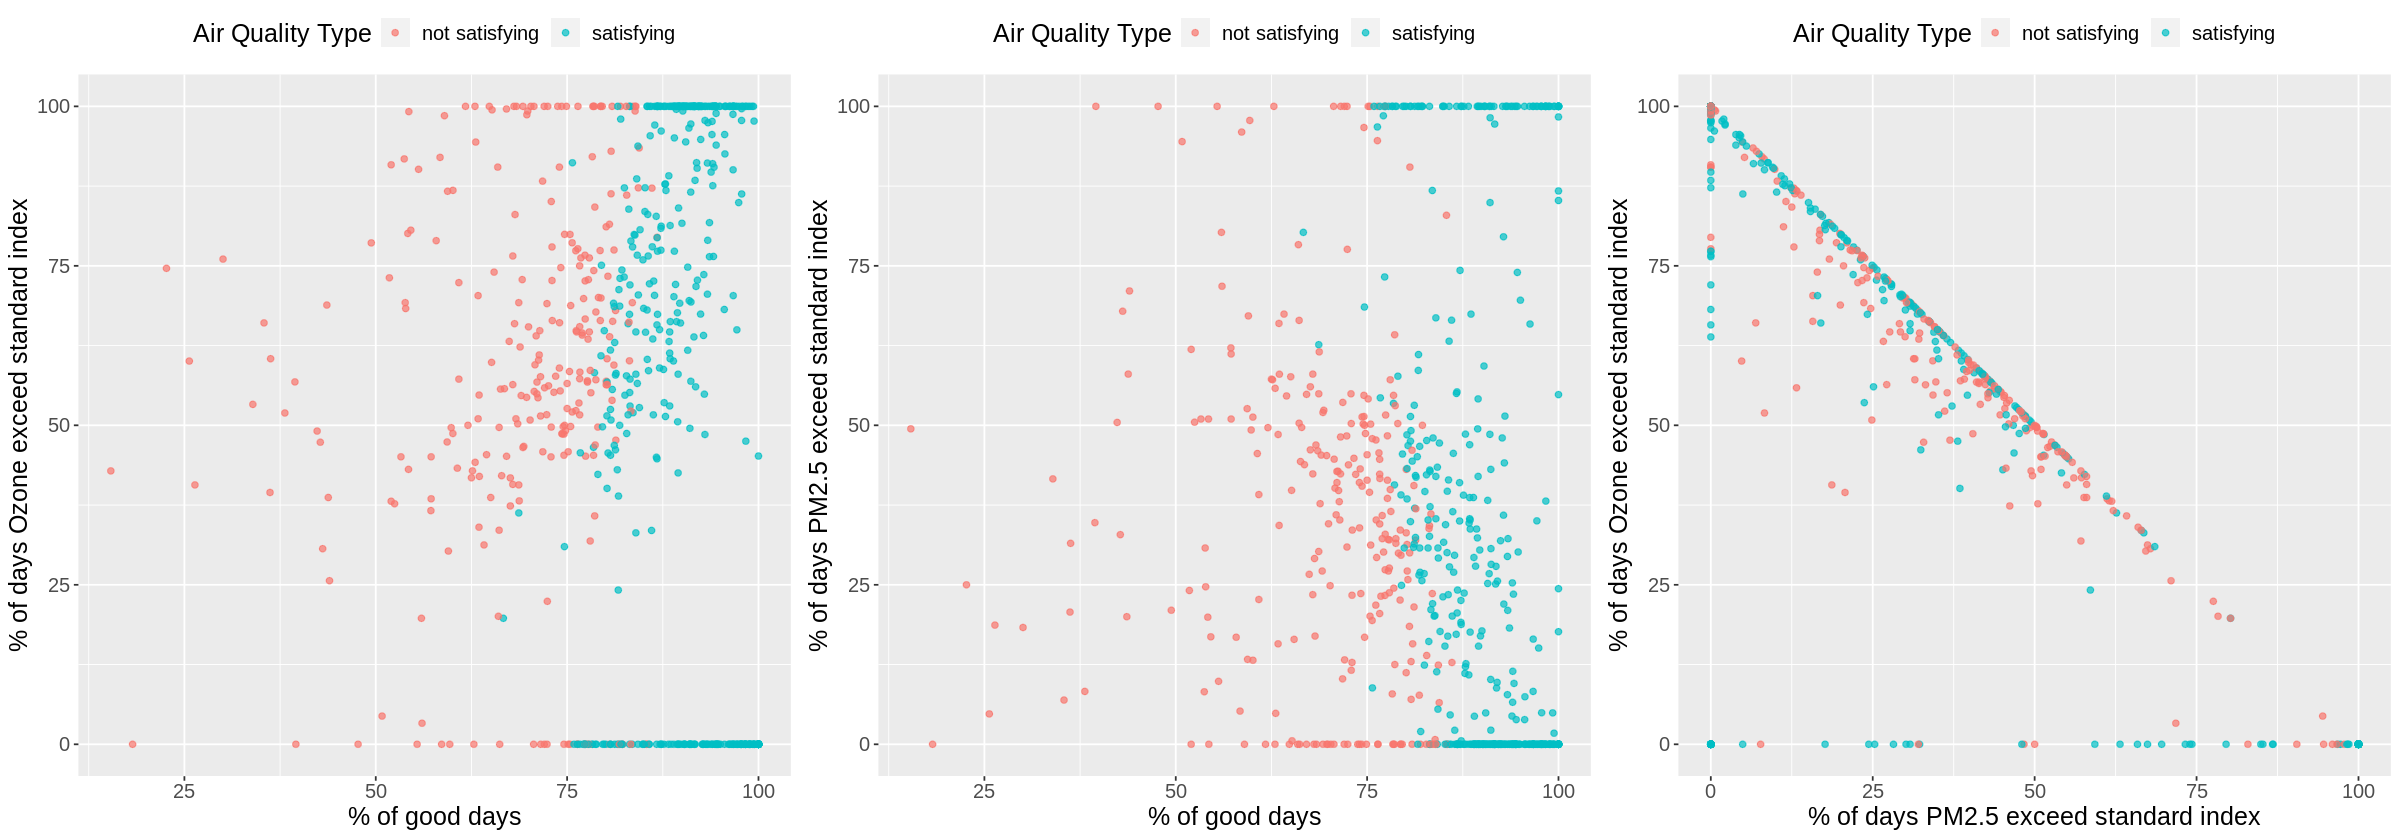

In [37]:
options(repr.plot.width = 20, repr.plot.height = 7)
train_plot1 <- ggplot(data = Air_quality_train,aes(x = per_good_days, y = per_days_Ozone)) +
    geom_point(aes(colour = air_quality_type), alpha = 0.7) +
    labs(colour = "Air Quality Type") +
    xlab("% of good days") + 
    ylab("% of days Ozone exceed standard index") +
    theme(text = element_text(size = 15), legend.position="top")

train_plot2 <- ggplot(data = Air_quality_train,aes(x = per_good_days, y = per_days_PM2.5)) +
    geom_point(aes(colour = air_quality_type), alpha = 0.7) +
    labs(colour = "Air Quality Type") +
    xlab("% of good days") + 
    ylab("% of days PM2.5 exceed standard index") +
    theme(text = element_text(size = 15), legend.position="top")

train_plot3 <- ggplot(data = Air_quality_train,aes(x = per_days_PM2.5, y = per_days_Ozone)) +
    geom_point(aes(colour = air_quality_type), alpha = 0.7) +
    labs(colour = "Air Quality Type") +
    xlab("% of days PM2.5 exceed standard index") + 
    ylab("% of days Ozone exceed standard index") +
    theme(text = element_text(size = 15),legend.position = "top")



    
plot_grid(train_plot1, train_plot2, train_plot3, ncol = 3)

## Method

We will focus on three variables, "days_Ozone","good_days","days_pm2.5", and their association with the air quality,
represented by the variable "90th_Percentile_AQI". By considering a value **higher than or equal to 60** as a 
"not satisfying" air quality and a value **lower than 60** as a "satisfying" air quality, we have two categories for
our prediction. We can then use each of the of the predictor variables to make a prediction about whether the air
quality will be "satisfying" or "not satisfying". By using the initial_split function in the tidymodels package, we
 split the data into a set of training data and a set of testing data. "prop= 0.70" will split the data into 70%
training data and 30% testing data. We will use K-nearest neighbours classification method to get our prediction.

We will visualize the result using scatter plot. By coloring different air quality types, we will be able to show the classification clearly. An example is provided below.

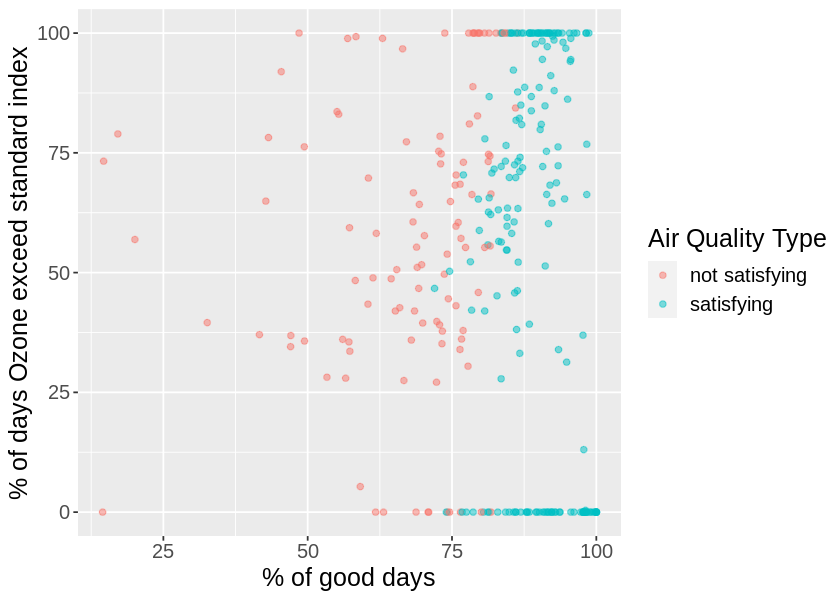

In [47]:
example_plot <- ggplot(data = Air_quality_test,aes(x = per_good_days, y = per_days_Ozone)) +
    geom_point(aes(colour = air_quality_type), alpha = 0.5) +
    labs(colour = "Air Quality Type") +
    xlab("% of good days") + 
    ylab("% of days Ozone exceed standard index") +
    theme(text = element_text(size = 15),legend.position = "right")
    options(repr.plot.width = 7, repr.plot.height = 5)
example_plot

## Expected outcomes and significance

With our model trained, we can now provide any county from the Air_quality_test data set and predict whether that county will be classified as `satisfying` or `not satisfying`. Furthermore, given any other county with its associated predictor values, we can determine what the classification of that new county will be. 

If a county has a high `90th_Percentile_AQI`, it indicates that overall, that county has worse quality of air compared to a county with lower `90th_Percentile_AQI`. 
This model and prediction could aid an individual to determine where they would like to move to, given the individual wants to live in a county with better air quality. It could also help the local governments see and compare their current air quality and make improvments if it's not within acceptable living standards. 